In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

In [ ]:
!pip install mlflow

In [5]:
!databricks configure --host https://community.cloud.databricks.com/
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/desmondstha125@gmail.com/toxic_comment_classification")

Username: desmondstha125@gmail.com
Password: 
Repeat for confirmation: 


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/287377935647537', creation_time=1690735613793, experiment_id='287377935647537', last_update_time=1690739821842, lifecycle_stage='active', name='/Users/desmondstha125@gmail.com/toxic_comment_classification', tags={'mlflow.experiment.sourceName': '/Users/desmondstha125@gmail.com/toxic_comment_classification',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'desmondstha125@gmail.com',
 'mlflow.ownerId': '6902679042209660'}>

Loading data from drive

In [6]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")
testText = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv')
testLevel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test_labels.csv/test_labels.csv")

In [ ]:
print("Shape of train data: ", train.shape)
print("Shape of test data: ", testText.shape)

Shape of train data:  (159571, 8)
Shape of test data:  (153164, 2)


In [ ]:
testText.head()

In [ ]:
testLevel.head()

In [ ]:
test = pd.merge(testText,testLevel, on='id')
test = test[test['toxic']!=-1]
test.head()

In [ ]:
train.describe()

Visualzing the data

<ipython-input-5-b8bd4b0944ea>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comment_len,kde=False, color="blue")


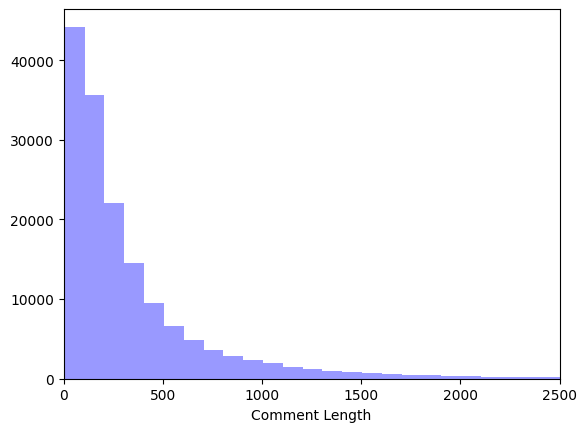

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len,kde=False, color="blue")
plt.xlim(0, 2500)

plt.xlabel('Comment Length')

# Display the plot
plt.show()

We can see most of the comments have short length and very few have length grater than 1000

Plotting the correlational matrix

<Axes: >

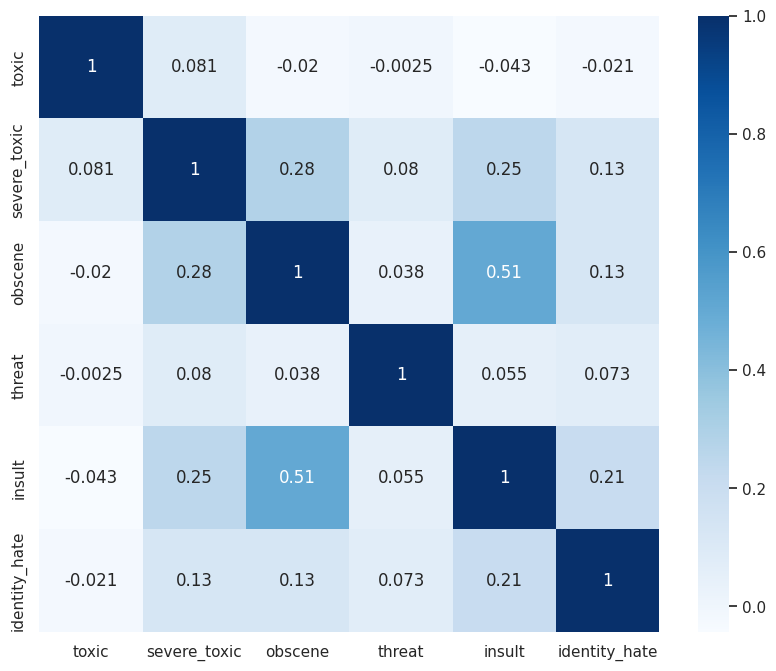

In [ ]:
rowsums = train.iloc[:, 2:8].sum(axis=1)
temp = train.iloc[:, 2:8]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

The highest levels of correlation can
be observed between the obscene and toxic

Preprocessing the data



1.   Removing Characters in between Text.
2. Removing Repeated Characters.

1.   Converting data to lower-case.
2.   Removing Punctuation.
3.   Removing unnecessary white spaces in between words.
2.   Removing “\n”.
3. Removing Non-English characters.





In [8]:
import re

def clean_text(text,remove_repeat_text=True, is_lower=True):

  if is_lower:
    text=text.lower()

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)  #removes repeated characters.
    # uses regular expressions (re) to find consecutive occurrences of a character
    # and replaces them with a single instance of that character.
    # For example, it replaces "loooove" with "love" by reducing consecutive repeated characters to a single occurrence

  text = str(text).replace("\n", " ") #replaces newline characters (\n) with a space character
  text = re.sub(r'[^\w\s]',' ',text) #substitute any non-alphanumeric and non-whitespace characters with a space character.
  text = re.sub('[0-9]',"",text) #remove any numeric digits from the text
  text = re.sub(" +", " ", text) #replace multiple consecutive spaces with a single space
  text = re.sub("([^\x00-\x7F])+"," ",text) #remove any non-ASCII characters from the text
  return text

train['comment_text'] = train['comment_text'].apply(clean_text)
test['comment_text'] = test['comment_text'].apply(clean_text)

Removing Stopwords using NLTK stopwords

In [11]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))

stop_words = set(stopwords.words('english'))

def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stop_words:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

#Removing Stopwords from Training Data
processed_train_data = []
for line in train["comment_text"]:
    processed_train_data.append(remove_stopwords(line))

#Removing Stopwords from Test Data
processed_test_data = []
for line in test["comment_text"]:
    processed_test_data.append(remove_stopwords(line))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
train["comment_text"] = processed_train_data
test["comment_text"] = processed_test_data
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


Tokenization

In [14]:
CATEGORIES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train = train["comment_text"]
y_train = train[CATEGORIES].values
X_test = test['comment_text']
y_test = test[CATEGORIES].values
X_train

0         explanation edits made username hardcore metal...
1         aww matches background colour seemingly stuck ...
2         hey man really trying edit war guy constantly ...
3         make real suggestions improvement wondered sec...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm theres actual article prostitution...
159569    looks like actually put speedy first version d...
159570    really think understand came idea bad right aw...
Name: comment_text, Length: 159571, dtype: object

In [110]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train_df = pd.DataFrame(y_train, columns=class_names)

for col in class_names:
  print(y_train_df[col].value_counts())
  print('\n')

0    144277
1     15294
Name: toxic, dtype: int64


0    157976
1      1595
Name: severe_toxic, dtype: int64


0    151122
1      8449
Name: obscene, dtype: int64


0    159093
1       478
Name: threat, dtype: int64


0    151694
1      7877
Name: insult, dtype: int64


0    158166
1      1405
Name: identity_hate, dtype: int64




Tokenization and Padding the sequence

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_features=100000
maxpadlen = 500

tokenizer = Tokenizer(num_words=max_features,oov_token='<nothing>')
tokenizer.fit_on_texts(X_train)

def tokenization(data):
  data = tokenizer.texts_to_sequences(data)
  data=pad_sequences(data, maxlen=maxpadlen, padding = 'post')
  return data

X_train = tokenization(X_train)
X_test = tokenization(X_test)

Saving the toekenization

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading the toekenizer. Note: First upload it to the files

In [ ]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Initaialing the word embedding using Sentence Transformer

Importing sentence transformer

In [ ]:
# !pip install sentence-transformers

In [ ]:
# from sentence_transformers import SentenceTransformer

# model_name = 'all-MiniLM-L6-v2'
# sentence_transformer_model = SentenceTransformer(model_name)

In [ ]:
# Converting sequences back to sentences
# sentences = tokenizer.sequences_to_texts(X_train)

# Obtaining sentence embeddings using the Sentence Transformer model
# sentence_embeddings = sentence_transformer_model.encode(sentences)

Saving the sentence_embedding in drive

In [ ]:
# df_embeddings = pd.DataFrame(sentence_embeddings)
# df_embeddings.to_csv('/content/drive/MyDrive/Colab Notebooks/sentence_embeddings.csv', index=False)

In [ ]:
# type(sentence_embeddings)

numpy.ndarray

Directly load the embedded sentences

In [16]:
loaded_df_embeddings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sentence_embeddings.csv')
sentence_embeddings = loaded_df_embeddings.values

In [17]:
import tensorflow
from keras.models import Model
from keras.layers import *
from keras.utils import plot_model

defining function for evaluation

In [199]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def threshold_calculation(class_names, y_test_df, y_pred_df):
  best_threshold = []
  fig, axs = plt.subplots(2, 3, figsize=(10, 5))

  for i, col in enumerate(class_names):
    precision, recall, thresholds = precision_recall_curve(y_test_df[col], y_pred_df[col])
    # Calculating F1-score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)
    # Find the index of the threshold that maximizes the F1-score
    best_threshold.append(thresholds[np.argmax(f1_scores)])
    ax = axs[i // 3, i % 3]
    ax.plot(recall, precision, color='b', label='Precision-Recall curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {col}')
    ax.legend(loc='lower left')

  plt.tight_layout()
  plt.show()
  plt.savefig('precision_recall.png')

  return best_threshold

def convert_to_binary_predictions(y_pred_df, thresholds):
    binary_predictions_df = y_pred_df.copy()
    for i, col in enumerate(y_pred_df.columns):
        binary_predictions_df[col] = (y_pred_df[col] >= thresholds[i]).astype(int)
    return binary_predictions_df

def overall_eval(y_test, y_pred):
  class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
  y_test_df = pd.DataFrame(y_test, columns=class_names)
  y_pred_df = pd.DataFrame(y_pred, columns=class_names)

  best_threshold = threshold_calculation(class_names, y_test_df, y_pred_df)

  y_pred = convert_to_binary_predictions(y_pred_df, best_threshold).to_numpy()

  y_true_flat = y_test.ravel()
  y_pred_flat = y_pred.ravel()
  accuracy = accuracy_score(y_true_flat, y_pred_flat)
  f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
  recall = recall_score(y_true_flat, y_pred_flat, average='weighted')
  precision = precision_score(y_true_flat, y_pred_flat, average='weighted')

  return accuracy, f1, recall, precision

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# for individuals levels
def evaluation(prediction, actual, col):
  accuracy = accuracy_score(actual[col], prediction[col])
  f1 = f1_score(actual[col], prediction[col], average='weighted')
  recall = recall_score(actual[col], prediction[col], average='weighted')
  precision = precision_score(actual[col], prediction[col], average='weighted')

  print("Accuracy of ",col , " is: " ,accuracy)
  print("F1-score of",col , " is: " ,f1)
  print("Recall of",col , " is: " ,recall)
  print("Precision of",col , " is: " ,precision)

# Plot the confusion matrix
def plot_confusion(prediction, actual, col):
  cm = confusion_matrix(actual[col], prediction[col])
  classes = [col]
  plt.figure(figsize=(4, 2))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix of '+ col)
  plt.show()


In [184]:
num_classes = 6
epochs = 10
batch_size = 128

Function for defining LSTM model

In [168]:
def lstmModel():
  inp=Input(shape=(maxpadlen, ),dtype='int32')
  embedding_layer = Embedding(input_dim=sentence_embeddings.shape[0],  # Number of words in the vocabulary
                            output_dim=sentence_embeddings.shape[1],  # Size of the embeddings
                            weights=[sentence_embeddings],  # Use the loaded embeddings
                            input_length=maxpadlen,
                            trainable=False)  # Freeze the embeddings
  embedded_sequences = embedding_layer(inp)
  x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
  x = GlobalMaxPool1D()(x)
  x = Dropout(0.2)(x)
  x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

  #Compile the Model.
  lstm_model = Model(inputs=inp, outputs=preds)

  lstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return lstm_model



In [181]:
model = lstmModel()

In [175]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 500, 384)          61275264  
                                                                 
 lstm_layer (LSTM)           (None, 500, 50)           87000     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 40)                2040      
                                                           

In [ ]:
plot_model(model, show_shapes=True)

In [182]:
# Training the LSTM model

import mlflow.keras

mlflow.end_run()
def train_model(model, name):
  with mlflow.start_run():
    mlflow.keras.autolog()
    history = model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,  validation_split = 0.2)
    # model.save('/content/drive/MyDrive/Colab Notebooks/Toxic_comments_models/' + name)
    y_pred = model.predict(X_test)
    # y_pred_labels = (y_pred > threshold).astype(int)

    accuracy, f1, recall, precision = overall_eval(y_test, y_pred)
    # accuracy, f1, recall, precision, overall_auc = overal_eval(y_test, y_pred)

    mlflow.log_param("Model", name)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("F1_score", f1)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Precision", precision)
    # mlflow.log_metric("Overall AUC", overall_auc)
    mlflow.log_artifact('precision_recall.png')
    plt.close()

  return history

1/1 [==============================] - 0s 347ms/step


2023/08/03 15:23:14 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.13+cuda11.cudnn86) contains a local version label (+cuda11.cudnn86). MLflow logged a pip requirement for this package as 'jaxlib==0.4.13' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2000/2000 [==============================] - 19s 9ms/step


<ipython-input-178-def8f1032b5b>:8: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
<ipython-input-178-def8f1032b5b>:8: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
<ipython-input-178-def8f1032b5b>:8: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


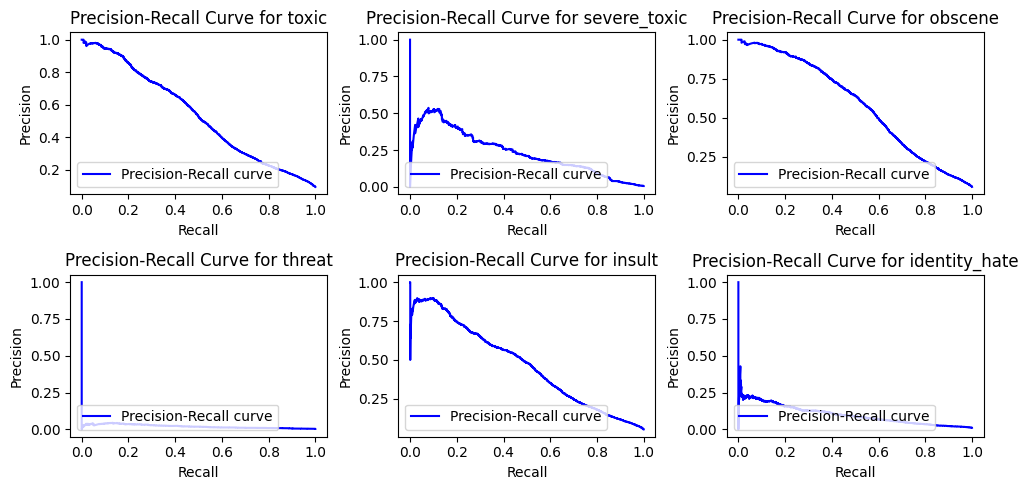

In [183]:
history = train_model(model, "LSTM model")

Plotting train vs test

In [ ]:
def plot_graph(history):
  plt.plot(history.history["accuracy"], label = "accuracy")
  plt.plot(history.history["val_accuracy"], label = "val_accuracy")
  plt.title("ACCURACY")
  plt.legend()
  plt.show()
  plt.plot(history.history["loss"], label = "loss")
  plt.plot(history.history["val_loss"], label = "val_loss")
  plt.title("LOSS")
  plt.legend()
  plt.show()

plot_graph(history)

Individual Level evaluations


In [ ]:
y_pred = model.predict(X_test)
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_test_df = pd.DataFrame(y_test, columns=class_names)
y_pred_df = pd.DataFrame(y_pred, columns=class_names)

best_threshold = threshold_calculation(class_names, y_test_df, y_pred_df)

y_pred = convert_to_binary_predictions(y_pred_df, best_threshold)

for col in class_names:
    evaluation(prediction=y_pred, actual=y_test_df, col=col)
    print('\n')

for col in class_names:
    plot_confusion(prediction=y_pred, actual=y_test_df, col=col)
    print('\n')

Making predictions

In [1]:
input_text = "you are a stupid"
processed_input_text = []
processed_input_text.append(remove_stopwords(input_text))
input_text = tokenization(processed_input_text)
model.predict(input_text)

NameError: ignored

Loading saved model from mlflow

In [32]:
# keras_model = mlflow.keras.load_model("dbfs:/databricks/mlflow-tracking/287377935647537/ad1711f885c34bc3bdf11daf54b1b4a5/artifacts/model")

Creating a Bidirectional LSTM model


In [39]:
from keras.layers import Bidirectional

def BilstmModel():
  inp=Input(shape=(maxpadlen, ),dtype='int32')
  embedding_layer = Embedding(input_dim=sentence_embeddings.shape[0],  # Number of words in the vocabulary
                            output_dim=sentence_embeddings.shape[1],  # Size of the embeddings
                            weights=[sentence_embeddings],  # Use the loaded embeddings
                            input_length=maxpadlen,
                            trainable=False)  # Freeze the embeddings
  embedded_sequences = embedding_layer(inp)
  x = Bidirectional(LSTM(50, return_sequences=True,name='lstm_layer'))(embedded_sequences)
  x = GlobalMaxPool1D()(x)
  x = Dropout(0.2)(x)
  x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

  #Compile the Model.
  bilstm_model = Model(inputs=inp, outputs=preds)

  bilstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return bilstm_model

model = BilstmModel()

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
history = train_model(model, "Bidirectional LSTM model")

In [ ]:
plot_graph(history)

Defining BiLSTM+CNN model

In [43]:
def Bilstm_CNNModel():
  inp=Input(shape=(maxpadlen, ),dtype='int32')
  embedding_layer = Embedding(input_dim=sentence_embeddings.shape[0],  # Number of words in the vocabulary
                              output_dim=sentence_embeddings.shape[1],  # Size of the embeddings
                              weights=[sentence_embeddings],  # Use the loaded embeddings
                              input_length=maxpadlen,
                              trainable=False)  # Freeze the embeddings
  embedded_sequences = embedding_layer(inp)
  x = Bidirectional(LSTM(50, return_sequences=True,name='lstm_layer'))(embedded_sequences)
  x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
  # x = MaxPooling1D(3)(x)
  x = GlobalMaxPool1D()(x)
  # x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

  #Compile the Model.
  combined_model = Model(inputs=inp, outputs=preds)

  combined_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return combined_model

model = Bilstm_CNNModel()

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
history = train_model(model, "Combined model")

In [ ]:
plot_graph(history)

In [ ]:
# BiLSTM_model = mlflow.keras.load_model("dbfs:/databricks/mlflow-tracking/287377935647537/35afb6e6f6d248c1a14ed3304c548f58/artifacts/model")
# BiLSTM_model.save('/content/drive/MyDrive/Colab Notebooks/Toxic_comments_models/BiLSTM')

In [53]:
loaded = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Toxic_comments_models/BiLSTM")

In [87]:
input_text = "Hi! I am back again! Last warning! Stop undoing my edits or die!"
processed_input_text = []
processed_input_text.append(remove_stopwords(input_text))
input_text = tokenization(processed_input_text)
input_text
BiLSTM_model.predict(input_text)

1/1 [==============================] - 0s 38ms/step


array([[0.5960075 , 0.03871097, 0.17253721, 0.08628885, 0.29329965,
        0.09768169]], dtype=float32)

In [86]:
input_text = "you are a stupid"
processed_input_text = []
processed_input_text.append(remove_stopwords(input_text))
input_text = tokenization(processed_input_text)
input_text
BiLSTM_model.predict(input_text)


1/1 [==============================] - 0s 49ms/step


array([[0.9559932 , 0.02825537, 0.62301314, 0.00639725, 0.6066191 ,
        0.03105692]], dtype=float32)